## Clustering und Anomaliedetektion in Geschmackseigenschaften von Single Malt Scotch Whiskys mit KMeans und Isolation Forest
Dieses Notebook ist Teil von <a href='https://datenverknoten.de/?p=656' target='_blank'>einem Artikel</a> auf www.datenverknoten.de.
<br>Quelle des verwendeten Datensatzes: https://www.kaggle.com/koki25ando/scotch-whisky-dataset

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import pickle

## Datenvorbereitung
Zunächst wird die CSV Datei geladen und es werden die nicht benötigten Spalten Postcode, Latitude, Longitude und RowID entfernt.

In [2]:
data = pd.read_csv('whisky.csv').drop(columns = ['Postcode','Latitude','Longitude','RowID'])

Nun wird die Matrix für das Clustering vorbereitet. Hierzu wird die Spalte Distillery entfernt. Im DataFrame <i>data</i> bleibt sie jedoch für spätere Schritte bestehen.

In [3]:
X = data.drop(columns = ['Distillery'])

## Bestimmung der Anzahl der Cluster mit der Elbow-curve
Im Artikel wurde bereits erwähnt, dass die fünf Hauptregionen der Whisky Brennerei in Schottland abgedeckt werden sollen. Trotzdem soll überprüft werden, ob entsprechend fünf Cluster eine plausible Wahl sind. Dies erkennt man in einer Elbow-curve daran, dass nach einem 'Knick' die Summe des Fehlers nicht mehr zunimmt. Der Fehler ist die Summer aller euklidischen Distanzen der einzelenen Instanzen zum Clusterzentrum.

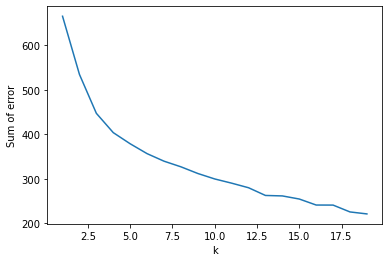

In [4]:
SumOfError = []
numCluster = range(1,20)
for k in numCluster:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    SumOfError.append(km.inertia_)
plt.plot(numCluster,SumOfError)
plt.xlabel('k')
plt.ylabel('Sum of error')
plt.show()

## Clustering
Das Clustering mit KMeans und fünf Clustern wird durchgeführt. Die Clusternummern werden den Instanzen im DataFrame zugeordnet.

In [5]:
kmeansmodel = KMeans(n_clusters = 5).fit(X)
labels = kmeansmodel.labels_
data['Clusters'] = labels

Die Visualisierung des Clustering ist nicht direkt möglich, da es 12 Geschmackstypen und dementsprechend 12 Dimensionen gibt, in denen geclustert wird. Durch Anwendung einer Dimensionalitätsreduktion, in diesem Falle <i>Principal Component Analysis</i> ist es möglich, die 12 Dimensionen auf 2 Dimensionen zu reduzieren. Dabei geht natürlich räumliche Information verloren, die Prinzipalkomponenten sind jedoch, einfach gesagt, die Komponenten, die die meißte Variablität in den Daten erklären. 

In [6]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

Die Darstellung der Cluster nach der Dimensionalitätsreduktion ist nun möglich. Es ist zu erkennen, dass sich einige Instanzen überlagern. Dies ist jedoch wahrscheinlich der Tatsache geschuldet, dass sie in einer der rationalisierten Dimensionen unterschiedlich sind. Dies ist hier dann nicht mehr sichtbar. Dennoch sind die Cluster sehr gut voneinander trennbar.

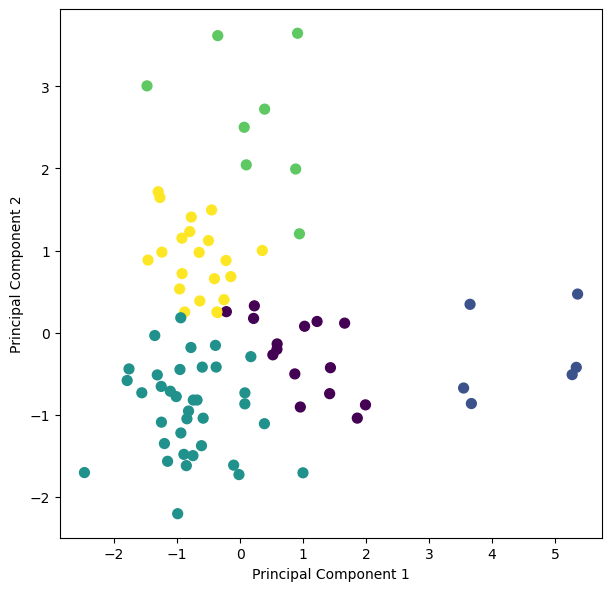

In [7]:
plt.figure(figsize=(7, 7), dpi=100)
plt.rcParams["font.size"] = 10
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=labels,s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Anomaliedetektion
Als nächstes werden die Ausreißer bestimmt. Hierbei wird nicht Clusterweise vorgegangen, sondern die Ausreißer werden in der Gesamtmenge der Daten bestimmt. Ob es sich dabei um einen Ausreißer handelt (1) oder nicht (-1) wird direkt im DataFrame gespeichert.

In [8]:
clf = IsolationForest(random_state=0).fit_predict(X)
data['Outlier'] = clf

Die geclusterten Instanzen werden nochmal basierend auf den beiden Prinzipalkomponenten dargestellt. Allerdings ist die Färbung diesmal basierend auf Ausreißer ja (dunkle Punkte) oder nein (helle Punkte). Zu sehen ist, dass das komplette Cluster auf der rechten Seite als Ausreißer angesehen wird. Auch einige der Instanzen am oberen Rand fallen deutlich heraus. 

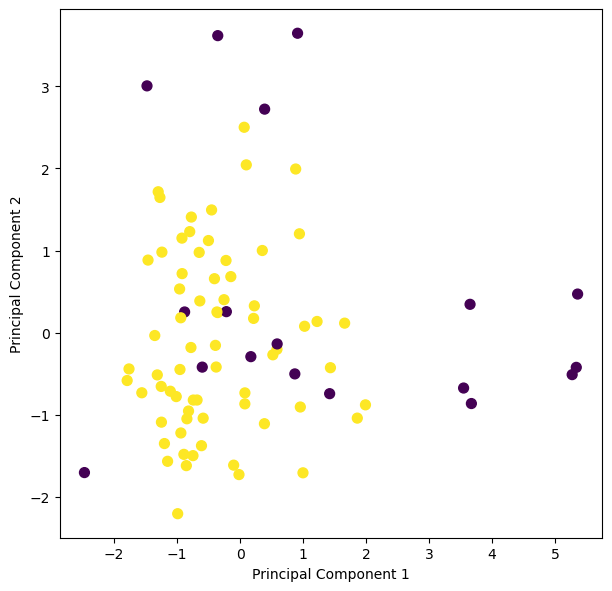

In [9]:
plt.figure(figsize=(7, 7), dpi=100)
plt.rcParams["font.size"] = 10
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=clf,s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Visualisierung des Unterschieds zwischen Cluster und Gesamtdaten
Im letzten Schritt sollen die unterschiedlichen Cluster so dargestellt werden, dass ihre Abgrenzung zur Gesamtmenge an Daten ersichtlich wird. Da pro Cluster 12 Geschmackseigenschaften dargestellt werden müssen, eigenen sich Netzdiagramme (<i>spider (web) diagram</i>) in meinen Augen besonders gut für diese Aufgabe. Zusätzlich sollen die Destillerien genannt werden, die in dieses Cluster fallen. Hervorgehoben werden sollen auch die Ausreißer. 

Es entsteht für jedes Cluster ein Netzdiagramm.

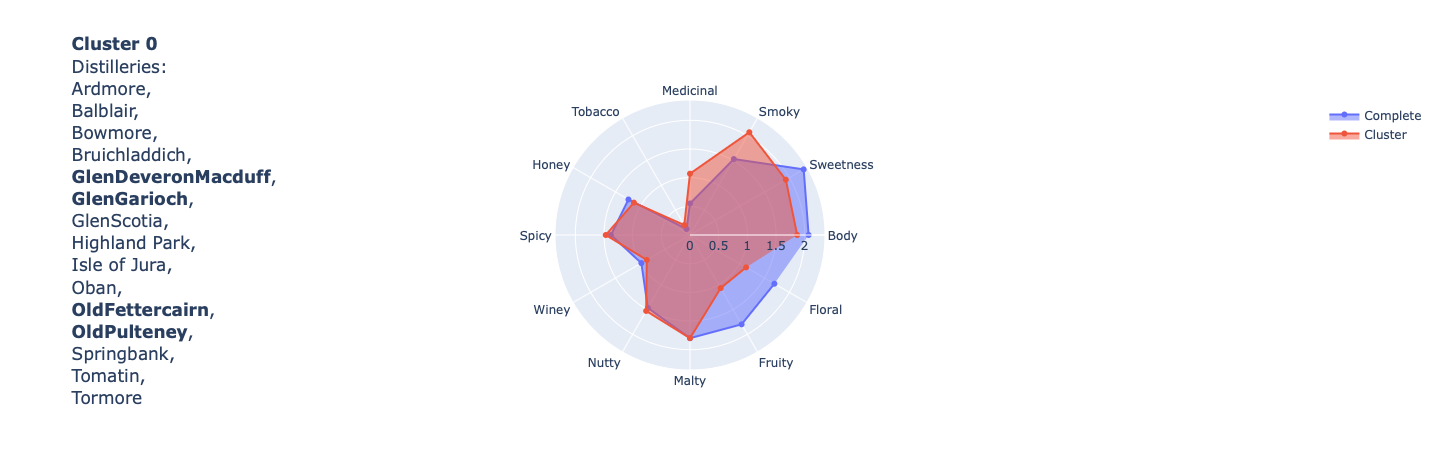

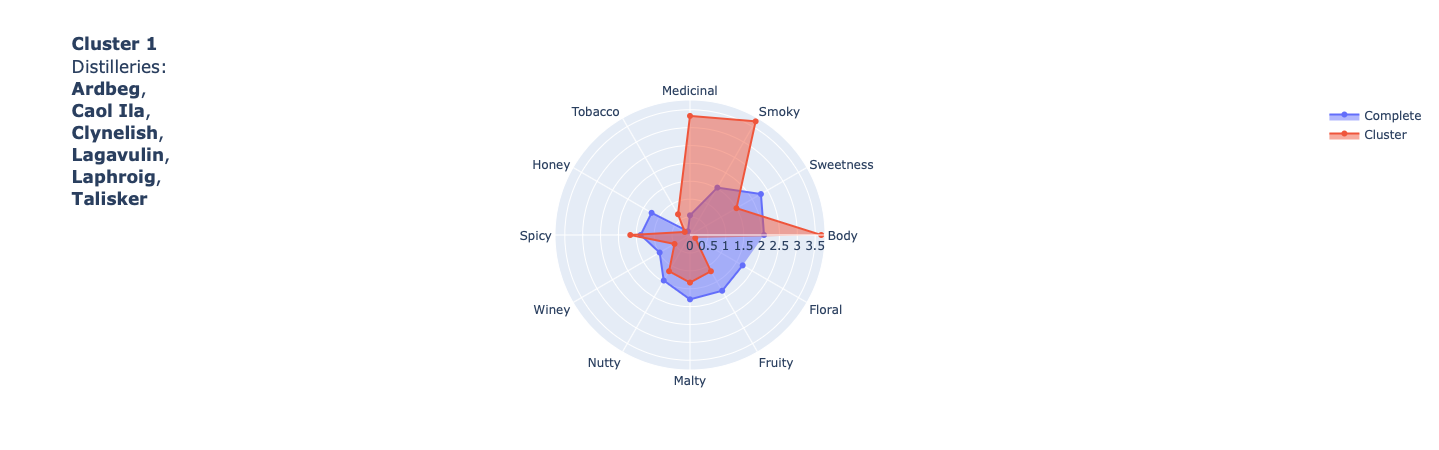

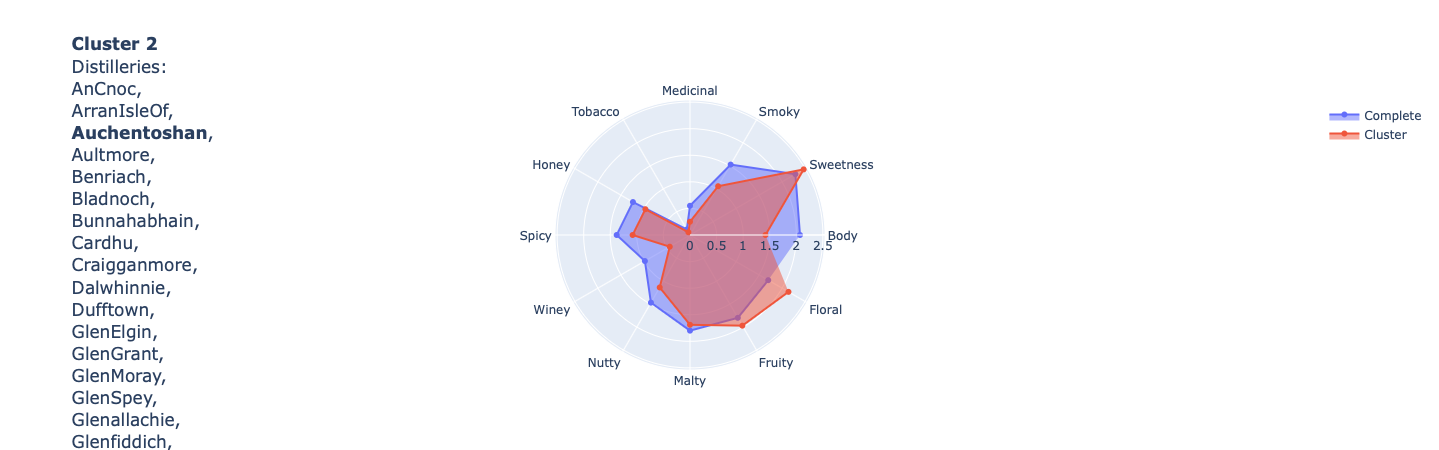

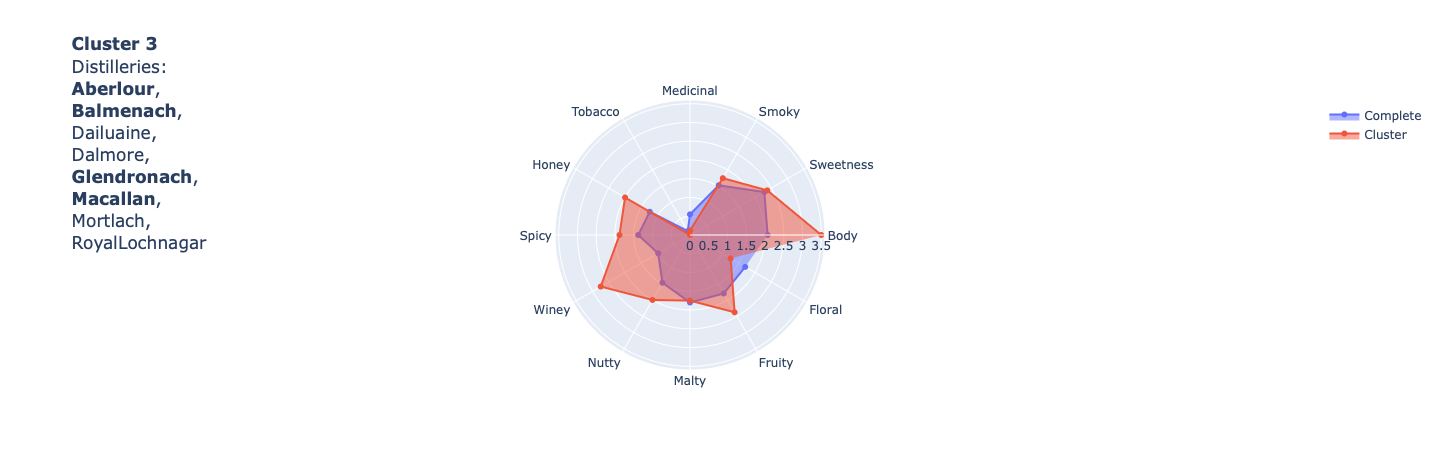

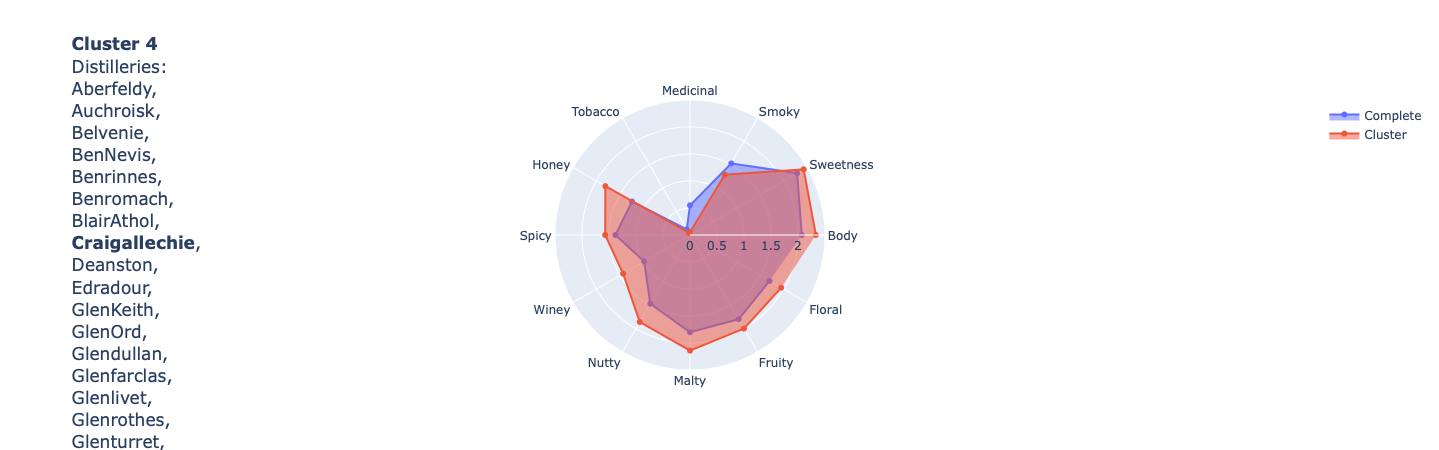

In [10]:
""" 
    Zunächst wird eine Tabelle, bestehend aus den Spalten 'Taste' und 'Value' erstellt, 
    welche die jeweiligen Mittelwerte der einzelnen Geschmäcker der Gesamtdaten enthalten.
    Die Mittelwerte werden auf zwei Nachkommastellen gerundet.
"""

avg_complete = pd.DataFrame(
    data.drop(columns=['Distillery','Clusters','Outlier']) \
    .mean() \
    .round(2) \
    .reset_index() \
)
avg_complete.columns=['Taste','Value']

"""
    Anschließend wird über jedes Cluster iteriert. Dabei muss zunächst natürlich das aktuelle Cluster aus den Gesamtdaten
    extrahiert werden. 
"""

for clsnr in sorted(data.Clusters.unique()):
    distillers_outlier_frame = data[data['Clusters']==clsnr][['Distillery','Outlier']].reset_index()
    distillers_string = ""

    """
    Hier wird nun als erstes der String mit den Namen der Destillen vorbereitet. Die Ausreißer sollen 
    fett ausgegeben werden. 
    """
    for i in range(0,len(distillers_outlier_frame)):
        if(distillers_outlier_frame.at[i,'Outlier']==-1):
            distillers_string += '<b>'+str(distillers_outlier_frame.at[i,'Distillery'])+'</b>,<br>'
        else:
            distillers_string += str(distillers_outlier_frame.at[i,'Distillery'])+',<br>'
    distillers_string = distillers_string[:-5]+'<br>'
    
    """
        Nun erfolgt die Aufbereitung der Daten des Clusters wie schon zu Beginn für die Gesamtdaten.
    """
    avg_cluster = pd.DataFrame(
        data[data['Clusters']==clsnr].drop(columns=['Distillery','Clusters','Outlier']) \
        .mean() \
        .round(2) \
        .reset_index() \
    )
    avg_cluster.columns=['Taste','Value']
    
    """
        Ein neues Diagramm wird initialisert und die Gesamtdaten, betitelt als 'Complete' werden hinzugefügt. r ist 
        eine Liste der Werte, theta die jeweiligen Eigenschaften (Ecken) des Diagramms.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
          r=avg_complete.Value.to_list(),
          theta=avg_complete.Taste.to_list(),
          fill='toself',
          name='Complete'
    ))

    """
        Hier werden die Daten aus dem Cluster hinzugefügt.
    """
    fig.add_trace(go.Scatterpolar(
          r=avg_cluster.Value.to_list(),
          theta=avg_cluster.Taste.to_list(),
          fill='toself',
          name='Cluster'
    ))

    """
        Zum Schluss wird die Legende und der Titel des Diagramms hinzugefügt. Der String wurde zu Beginn dieser 
        Schleife erstellt. Dann wird das Diagramm geplottet und es folgt das nächste Cluster. Die Grafiken sind 
        übrigens interaktiv. Wenn man mit der Maus über einen Datenpunkt hovert, wird der zugehörige Wert angezeigt.
    """
    fig.update_layout(
        polar = dict(
            radialaxis = dict(
                visible = True
            )),
        showlegend = True,
        title = '<b>Cluster '+str(clsnr)+'</b><br>Distilleries:<br>'+str(distillers_string)
    )

    fig.show()

Das Modell muss noch serialisiert und gespeichert werden, damit es in der Webapplikation wiederverwendet werden kann. Auch wird hier der DataFrame ohne die Geschmackseigenschaften gespeichert. In der Webapplikation brauchen wir nämlich nur die Clusternummer der jeweiligen Instanz und ob es sich um einen Ausreißer handelt.

In [11]:
with open("kmeansmodel.pkl", "wb") as f:
    pickle.dump(kmeansmodel, f)
    
data[['Distillery','Clusters','Outlier']].to_csv('extended_whisky_dataset.csv')

## Schlusswort
Die Diskussion der Ergebnisse findet im Artikel statt. 